In [1]:
import csv
import gzip
import os
import matplotlib
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import Birch, AffinityPropagation, DBSCAN, MeanShift, SpectralClustering, AgglomerativeClustering, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
matrix_dir = "genesrna"
mat = pd.read_csv("genesrna/dataset4.csv")
mat = np.array(mat)
datafile = 'dataset4.tpm.txt'
df = pd.read_csv(datafile, sep='\t')
df = df.set_index('gene_name')
cells = list(df.columns.values)
features_path = os.path.join(matrix_dir, "features4.txt")
annotation  = pd.read_csv(features_path,sep='\t',header=None)
annotation.columns = ['gene_names']
barcodes_path = os.path.join(matrix_dir, "barcodes4.txt")
barcodes = [line.strip() for line in open(barcodes_path, 'r')]
mat = mat.T 
print('compiled!')
print(mat.shape)

compiled!
(518, 57822)


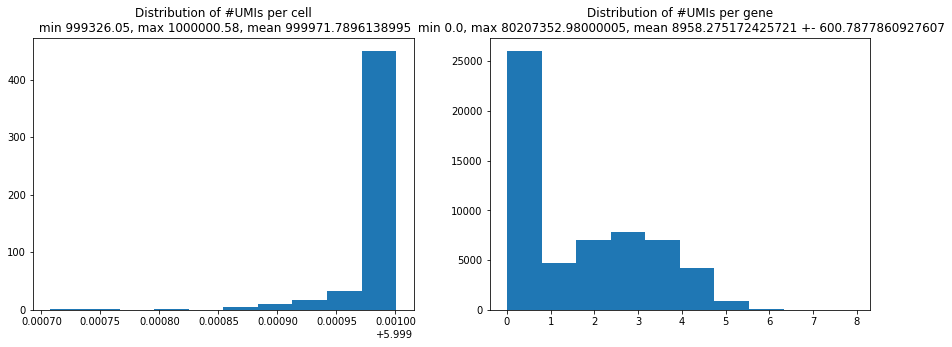

In [6]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis=1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))));

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1));
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +- {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))));

(518, 13720)


Text(0.5, 1.0, 'Distribution of CV, mean 0.7336748386076576 sd 0.7539717748791853')

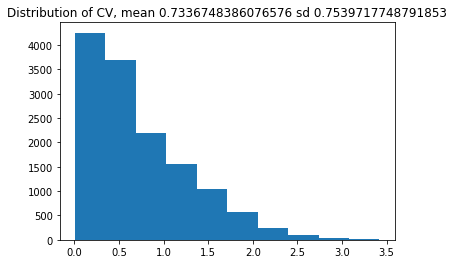

In [7]:
low_expr_thr = 1000
high_expr_thr = 80000000
mat = mat[:, (per_gene_sum>=low_expr_thr) & (per_gene_sum<=high_expr_thr)]
print(mat.shape)
mean_exp = mat.mean(axis=0)
std_exp = np.sqrt(mat.std(axis=0))
CV = std_exp/mean_exp
plt.hist(CV)
plt.title('Distribution of CV, mean {} sd {}'.format(np.mean(CV), np.std(CV)**0.5))

Text(0.5, 1.0, 'Distribution of #UMIs per gene\n min 1000.31, max 26509.84, mean 2741.465768703337 +1 40.688649641238904')

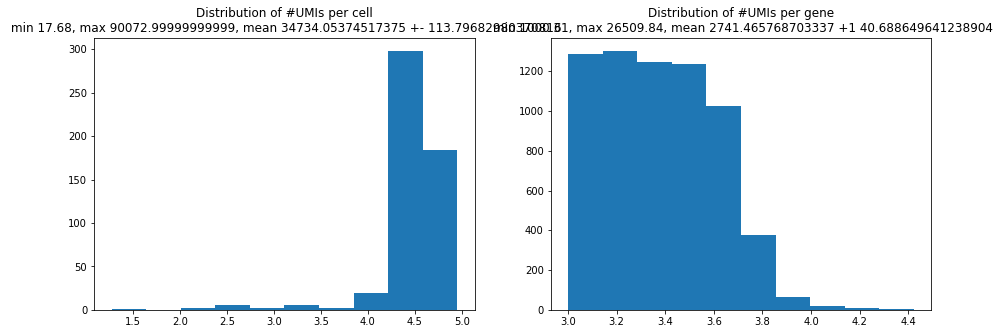

In [8]:
mat = mat[:, CV >= 0.6]
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis = 1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {} +- {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))))

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1))
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +1 {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))))

(517, 6563)
done


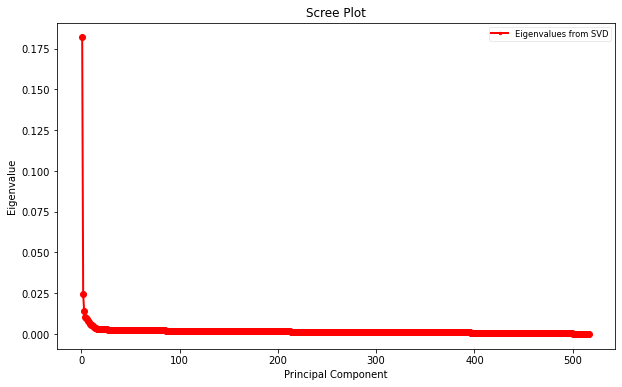

In [9]:
cells_expression = mat.sum(axis=1)
mat = mat[cells_expression>=100, :]
mat = np.log(mat+1)
U, S, V = np.linalg.svd(mat) 
eigvals = S**2 / np.sum(S**2)  # NOTE (@amoeba): These are not PCA eigenvalues. 
                               # This question is about SVD.

fig = plt.figure(figsize=(10, 6))
sing_vals = np.arange(len(mat)) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
#leg.draggable(state=True)
print(mat.shape)
print('done')

(517, 6563)


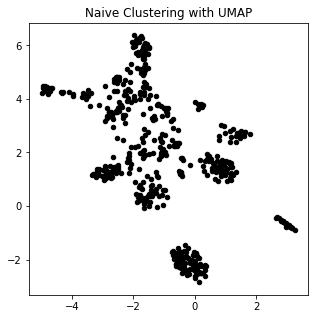

In [10]:
print(mat.shape)
pca = PCA(n_components=90)
pca.fit(mat)
mat_reduce=pca.transform(mat)
embedding = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='euclidean').fit_transform(mat_reduce)
plt.figure(figsize=(5, 5))
plt.scatter(embedding[:,0],embedding[:,1], s=20, c='black')
plt.title('Naive Clustering with UMAP')
plt.savefig('Naive Clustering.png')

AffinityPropagation
[137 168 116  96]
MeanShift
[517]
SpectralClustering
[461  25  11  20]
Ward
[195 100  76 146]
AgglomerativeClustering
[400  21  76  20]
DBSCAN
[ 20  41  48  11   8 114  23  23  45  54   8  15  76   8   5]
Birch
[240  84  96  97]
GaussianMixture
[142  96 174 105]


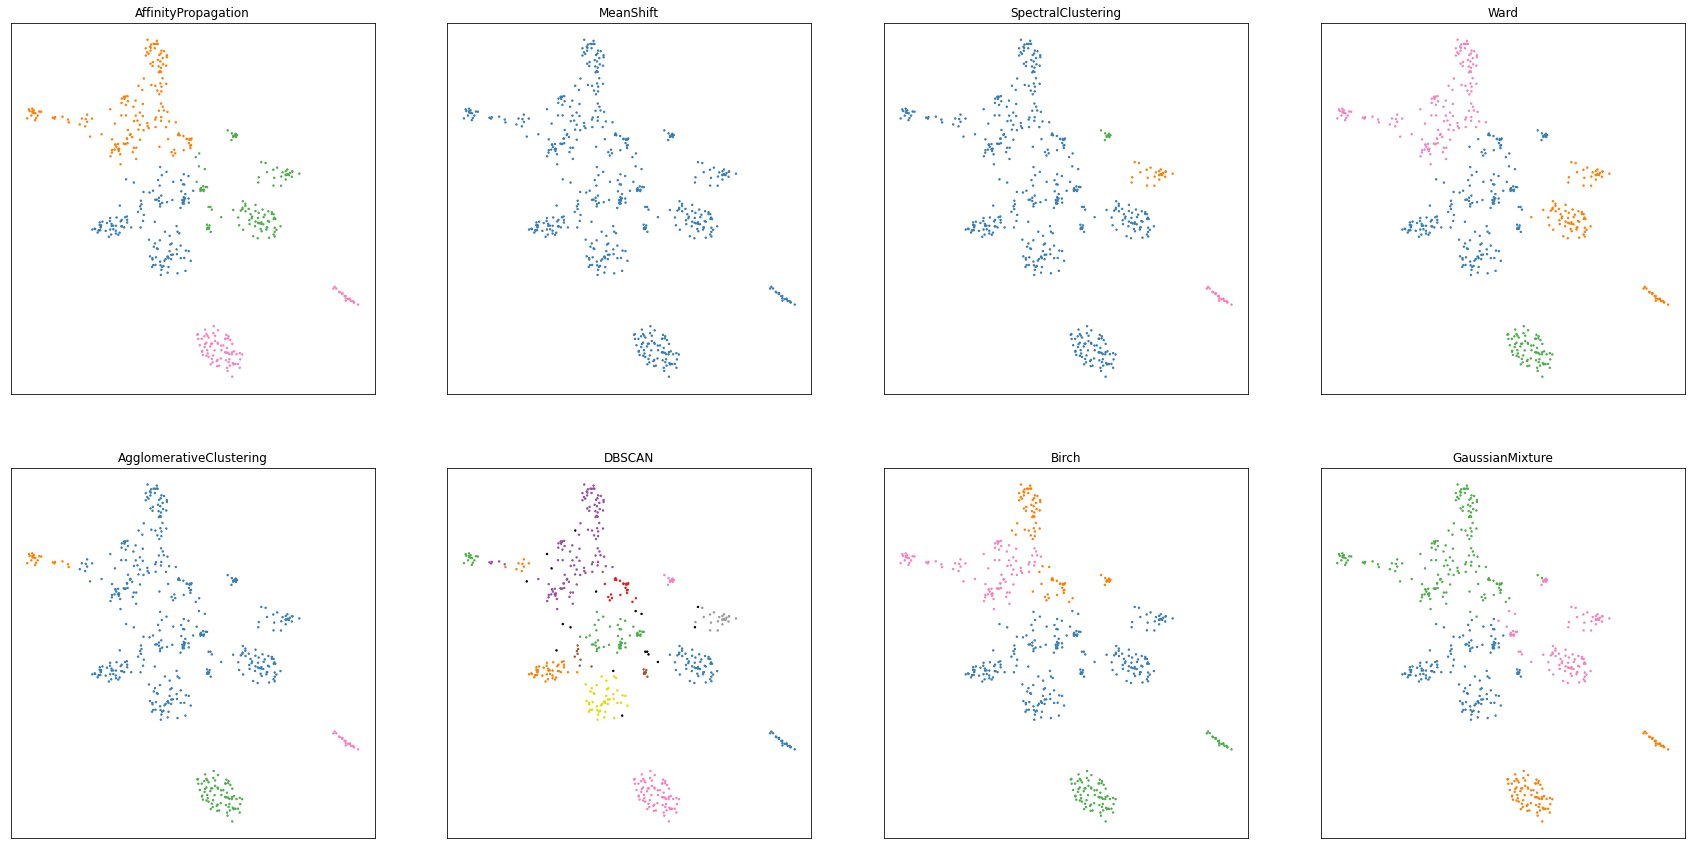

In [11]:
params = {'quantile': .3, 'eps': .3, 'damping': .9, 'preference':-200, 'n_neighbors':30, 'n_clusters':4}
bandwidth = estimate_bandwidth(embedding, quantile=params['quantile'])
connectivity = kneighbors_graph(embedding, n_neighbors=params['n_neighbors'], include_self = False)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ward = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
spectral = SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = DBSCAN(eps=params['eps'])
affinity_propagation = AffinityPropagation(damping=params['damping'], preference=params['preference'])
average_linkage = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
birch = Birch(n_clusters=params['n_clusters'])
gmm = GaussianMixture(n_components=params['n_clusters'], covariance_type='full')
clustering_algorithms = ( 
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm))
#now plot everything
f, ax = plt.subplots(2, 4, figsize=(30,15))
for idx, (name, algorithm) in enumerate(clustering_algorithms):
    algorithm.fit(embedding)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    ax[idx//4, idx%4].scatter(embedding[:, 0], embedding[:, 1], s=2, color=colors[y_pred])
    #ax[idx//4, idx%4].xlim(-2.5, 2.5)
    #ax[idx//4, idx%4].ylim(-2.5, 2.5)
    ax[idx//4, idx%4].set_xticks(())
    ax[idx//4, idx%4].set_yticks(())
    ax[idx//4, idx%4].set_title(name)

    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_
    else:
        labels = algorithm.predict(embedding)
    
    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])

    print('{}'.format(name))
    print(counts)
plt.savefig('All Clusters.png')


In [18]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

def ClusterIndicesComp(clustNum, labels_array): #list comprehension
    return np.array([i for i, x in enumerate(labels_array) if x == clustNum])

def DataCollection(algorithm, cluster_1, cluster_2, cluster_3, cluster_4, results):
    num1 = ClusterIndicesNumpy(0, algorithm.labels_)
    num2 = ClusterIndicesNumpy(1, algorithm.labels_)
    num3 = ClusterIndicesNumpy(2, algorithm.labels_)
    num4 = ClusterIndicesNumpy(3, algorithm.labels_)
    barcodes1 = []
    barcodes2 = []
    barcodes3 = []
    barcodes4 = []
    for i in num1:
        barcodes1.append(cells[i])
    for i in num2:
        barcodes2.append(cells[i])
    for i in num3:
        barcodes3.append(cells[i])
    for i in num4:
        barcodes4.append(cells[i])
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
    with open(cluster_4, 'w') as filehandle:
        for listitem in barcodes4:
            filehandle.write('%s\n' % listitem)
        
        
    dp = open('DPCells.txt').readlines()
    dp_line = []
    for lines in dp:
        dp_line.append(lines)
    erp = open('ERPCells.txt').readlines()
    erp_line = []
    for lines in erp:
        erp_line.append(lines)
    her2p = open('HER2PCells.txt').readlines()
    her2p_line = []
    for lines in her2p:
        her2p_line.append(lines)
        
    tnbc = open('TNBCCells.txt').readlines()
    tnbc_line = []
    for lines in tnbc:
        tnbc_line.append(lines)
        
    res = open(results, "w")

    dpcount = 0
    erpcount = 0
    her2pcount = 0
    tnbccount = 0

    dpcount2 = 0
    erpcount2 = 0
    her2pcount2 = 0
    tnbccount2 = 0
    
    dpcount3 = 0
    erpcount3 = 0
    her2pcount3 = 0
    tnbccount3 = 0
    
    dpcount4 = 0
    erpcount4 = 0
    her2pcount4 = 0
    tnbccount4 = 0

    
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in dp_line:
            if i == j:
                dpcount = dpcount + 1
    res.write("DP Count Cluster 1: \n")
    res.write(str(dpcount/(len(cluster1_line))) + " \n")
    res.write(str(dpcount) + " \n")
    for i in cluster1_line:
        for j in erp_line:
            if i == j:
                erpcount = erpcount + 1
    res.write("ERP Count Cluster 1: \n")
    res.write(str(erpcount/(len(cluster1_line))) + "\n")
    res.write(str(erpcount) + "\n")
    for i in cluster1_line:
        for j in her2p_line:
            if i == j:
                her2pcount = her2pcount + 1
    res.write("HER2P Count Cluster 1: \n")
    res.write(str(her2pcount/(len(cluster1_line))) + "\n")
    res.write(str(her2pcount) + "\n")
    for i in cluster1_line:
        for j in tnbc_line:
            if i == j:
                tnbccount = tnbccount + 1
    res.write("TNBC Count Cluster 1: \n")
    res.write(str(tnbccount/(len(cluster1_line))) + "\n")
    res.write(str(tnbccount) + "\n")
    res.write("\n")
    

    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in dp_line:
            if i == j:
                dpcount2 = dpcount2 + 1
    res.write("DP Count Cluster 2:" + "\n")
    res.write(str(dpcount2/(len(cluster2_line))) + "\n")
    res.write(str(dpcount2) + "\n")
    for i in cluster2_line:
        for j in erp_line:
            if i == j:
                erpcount2 = erpcount2 + 1
    res.write("ERP Count Cluster 2:" + "\n")
    res.write(str(erpcount2/(len(cluster2_line))) + "\n")
    res.write(str(erpcount2) + "\n")
    for i in cluster2_line:
        for j in her2p_line:
            if i == j:
                her2pcount2 = her2pcount2 + 1
    res.write("HER2P Count Cluster 2: \n")
    res.write(str(her2pcount2/(len(cluster2_line))) + "\n")
    res.write(str(her2pcount2) + "\n")
    for i in cluster2_line:
        for j in tnbc_line:
            if i == j:
                tnbccount2 = tnbccount2 + 1
    res.write("TNBC Count Cluster 2: \n")
    res.write(str(tnbccount2/(len(cluster2_line))) + "\n")
    res.write(str(tnbccount2) + "\n")
    res.write("\n")
    

    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in dp_line:
            if i == j:
                dpcount3 = dpcount3 + 1
    res.write("DP Count Cluster 3:" + "\n")
    res.write(str(dpcount3/(len(cluster3_line))) + "\n")
    res.write(str(dpcount3) + "\n")
    for i in cluster3_line:
        for j in erp_line:
            if i == j:
                erpcount3 = erpcount3 + 1
    res.write("ERP Count Cluster 3:" + "\n")
    res.write(str(erpcount3/(len(cluster3_line))) + "\n")
    res.write(str(erpcount3) + "\n")
    for i in cluster3_line:
        for j in her2p_line:
            if i == j:
                her2pcount3 = her2pcount3 + 1
    res.write("HER2P Count Cluster 3:" + "\n")
    res.write(str(her2pcount3/(len(cluster3_line))) + "\n")
    res.write(str(her2pcount3) + "\n")
    for i in cluster3_line:
        for j in tnbc_line:
            if i == j:
                tnbccount3 = tnbccount3 + 1
    res.write("TNBC Count Cluster 3:" + "\n")
    res.write(str(tnbccount3/(len(cluster3_line))) + "\n")
    res.write(str(tnbccount3) + "\n")
    res.write("\n")
    
    cluster4 = open(cluster_4).readlines()
    cluster4_line = []
    for lines in cluster4:
        cluster4_line.append(lines)
    for i in cluster4_line:
        for j in dp_line:
            if i == j:
                dpcount4 = dpcount4 + 1
    res.write("DP Count Cluster 4:" + "\n")
    res.write(str(dpcount4/(len(cluster4_line))) + "\n")
    res.write(str(dpcount4) + "\n")
    for i in cluster4_line:
        for j in erp_line:
            if i == j:
                erpcount4 = erpcount4 + 1
    res.write("ERP Count Cluster 4:" + "\n")
    res.write(str(erpcount4/(len(cluster4_line))) + "\n")
    res.write(str(erpcount4) + "\n")
    for i in cluster4_line:
        for j in her2p_line:
            if i == j:
                her2pcount4 = her2pcount4 + 1
    res.write("HER2P Count Cluster 4:" + "\n")
    res.write(str(her2pcount4/(len(cluster4_line))) + "\n")
    res.write(str(her2pcount4) + "\n")
    for i in cluster4_line:
        for j in tnbc_line:
            if i == j:
                tnbccount4 = tnbccount4 + 1
    res.write("TNBC Count Cluster 4:" + "\n")
    res.write(str(tnbccount4/(len(cluster4_line))) + "\n")
    res.write(str(tnbccount4) + "\n")
    res.write("\n")

DataCollection(spectral, 'spectral_cluster1.txt', 'spectral_cluster2.txt', 'spectral_cluster3.txt', 'spectral_cluster4.txt','spectral_results.txt')
DataCollection(ward, 'ward_cluster1.txt', 'ward_cluster2.txt', 'ward_cluster3.txt', 'ward_cluster4.txt', 'ward_results.txt')